In [ ]:
import os, glob, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/Stat483-GOALZ/sleepedf_processed'
RESULT_DIR = '/content/drive/MyDrive/Stat483-GOALZ/sleepedf_results'
os.makedirs(RESULT_DIR, exist_ok=True)

In [ ]:
print("Files in directory:", os.listdir(DATA_DIR))

Files in directory: ['ST7242J0_sequences.npz', 'ST7242J0_epochs.npz', 'ST7241J0_sequences.npz', 'ST7241J0_epochs.npz', 'ST7221J0_sequences.npz', 'ST7221J0_epochs.npz', 'ST7212J0_sequences.npz', 'ST7212J0_epochs.npz', 'ST7211J0_sequences.npz', 'ST7211J0_epochs.npz', 'ST7202J0_sequences.npz', 'ST7202J0_epochs.npz', 'ST7201J0_sequences.npz', 'ST7201J0_epochs.npz', 'ST7192J0_sequences.npz', 'ST7192J0_epochs.npz', 'ST7191J0_sequences.npz', 'ST7191J0_epochs.npz', 'ST7182J0_sequences.npz', 'ST7182J0_epochs.npz', 'ST7181J0_sequences.npz', 'ST7181J0_epochs.npz', 'ST7172J0_sequences.npz', 'ST7172J0_epochs.npz', 'ST7171J0_sequences.npz', 'ST7171J0_epochs.npz', 'ST7162J0_sequences.npz', 'ST7162J0_epochs.npz', 'ST7161J0_sequences.npz', 'ST7161J0_epochs.npz', 'ST7152J0_sequences.npz', 'ST7152J0_epochs.npz', 'ST7151J0_sequences.npz', 'ST7151J0_epochs.npz', 'ST7142J0_sequences.npz', 'ST7142J0_epochs.npz', 'ST7141J0_sequences.npz', 'ST7141J0_epochs.npz', 'ST7132J0_sequences.npz', 'ST7132J0_epochs.npz',

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
TRAIN_VAL_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [ ]:
EMBEDDING_DIM = 128   # Dimension of the CNN encoder output per epoch
NUM_CLASSES = 5       # 0: Wake, 1: N1, 2: N2, 3: N3, 4: REM
NUM_TRANSFORMER_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.1
SEQ_LENGTH = 20       # Number of epochs per sequence (must match preprocessing)

In [ ]:
class SleepSequenceDataset(Dataset):
    def __init__(self, data_dir):
        # Find all NPZ files ending with _sequences.npz
        self.files = glob.glob(os.path.join(data_dir, '*_sequences.npz'))
        sequences_list = []
        labels_list = []
        for f in self.files:
            loaded = np.load(f)
            sequences_list.append(loaded['sequences'])  # shape: (n_seq, 20, 2, 3000)
            labels_list.append(loaded['seq_labels'])      # shape: (n_seq, 20)
        self.sequences = np.concatenate(sequences_list, axis=0)
        self.seq_labels = np.concatenate(labels_list, axis=0)
        self.sequences = torch.from_numpy(self.sequences).float()
        self.seq_labels = torch.from_numpy(self.seq_labels).long()

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.seq_labels[idx]

In [ ]:
class EpochEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(EpochEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=50, stride=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        #Passing dummy input to automatically calculate no. of features and avoid mismatch error
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 3000)
            dummy_output = self.net(dummy_input)
            n_features = dummy_output.numel() // dummy_output.shape[0]  # Total features per sample
        self.fc = nn.Linear(n_features, embedding_dim)
        # The output dimension is computed approximately based on the input size 3000
        #self.fc = nn.Linear(32 * (((3000 - 50) // 6 + 1) // 8 // 4), embedding_dim)

    def forward(self, x):
        # x: (batch, 2, 3000)
        out = self.net(x)
        out = out.view(out.size(0), -1)
        embedding = self.fc(out)
        return embedding

In [ ]:
class SleepTransformer(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_layers, num_heads, dropout, seq_length):
        super(SleepTransformer, self).__init__()
        self.encoder = EpochEncoder(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        self.seq_length = seq_length

    def forward(self, x):
        # x: (batch, seq_length, 2, 3000)
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(-1, x.size(2), x.size(3))  # (batch*seq_length, 2, 3000)
        epoch_emb = self.encoder(x)           # (batch*seq_length, embedding_dim)
        epoch_emb = epoch_emb.view(batch_size, seq_len, -1)
        epoch_emb = epoch_emb.transpose(0, 1)   # (seq_length, batch, embedding_dim)
        transformer_out = self.transformer(epoch_emb)
        transformer_out = transformer_out.transpose(0, 1)  # (batch, seq_length, embedding_dim)
        logits = self.classifier(transformer_out)  # (batch, seq_length, num_classes)
        return logits

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for seq, labels in dataloader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seq)  # (batch, seq_length, num_classes)
        loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * seq.size(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.append(preds.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc

In [ ]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            logits = model(seq)
            loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
            running_loss += loss.item() * seq.size(0)
            preds = torch.argmax(logits, dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc, all_preds, all_labels

In [ ]:
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['W', 'N1', 'N2', 'N3', 'R']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def main():
    # Load dataset from processed sequence NPZ files
    dataset = SleepSequenceDataset(DATA_DIR)
    total_len = len(dataset)
    train_len = int(TRAIN_VAL_SPLIT * total_len)
    val_len = total_len - train_len
    train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = SleepTransformer(EMBEDDING_DIM, NUM_CLASSES, NUM_TRANSFORMER_LAYERS, NUM_HEADS, DROPOUT, SEQ_LENGTH)
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in tqdm(range(1, NUM_EPOCHS+1), desc="Training Epochs"):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc, val_preds, val_labels = eval_epoch(model, val_loader, criterion, DEVICE)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch}/{NUM_EPOCHS}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    plot_curves(train_losses, val_losses, train_accs, val_accs)
    _, _, val_preds, val_labels = eval_epoch(model, val_loader, criterion, DEVICE)
    plot_confusion(val_labels, val_preds)

    # Save the model checkpoint in RESULT_DIR
    torch.save(model.state_dict(), os.path.join(RESULT_DIR, 'sleep_transformer_model.pth'))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Train Loss=1.1900, Train Acc=0.5418, Val Loss=0.8678, Val Acc=0.6772
Epoch 2/20: Train Loss=0.7787, Train Acc=0.7055, Val Loss=0.7576, Val Acc=0.7228
Epoch 3/20: Train Loss=0.6593, Train Acc=0.7516, Val Loss=0.6645, Val Acc=0.7532
Epoch 4/20: Train Loss=0.6069, Train Acc=0.7721, Val Loss=0.6847, Val Acc=0.7534
Epoch 5/20: Train Loss=0.5833, Train Acc=0.7812, Val Loss=0.5874, Val Acc=0.7705
Epoch 6/20: Train Loss=0.5912, Train Acc=0.7830, Val Loss=0.7842, Val Acc=0.6846
Epoch 7/20: Train Loss=0.5247, Train Acc=0.8047, Val Loss=0.5890, Val Acc=0.7874
Epoch 8/20: Train Loss=0.4842, Train Acc=0.8207, Val Loss=0.5876, Val Acc=0.7799
Epoch 9/20: Train Loss=0.4639, Train Acc=0.8282, Val Loss=0.6686, Val Acc=0.7475
Epoch 10/20: Train Loss=0.4477, Train Acc=0.8290, Val Loss=0.5522, Val Acc=0.7991
Epoch 11/20: Train Loss=0.4387, Train Acc=0.8367, Val Loss=0.5908, Val Acc=0.7792
Epoch 12/20: Train Loss=0.4254, Train Acc=0.8396, Val Loss=0.5237, Val Acc=0.8073
Epoch 13/20: Train Loss=0

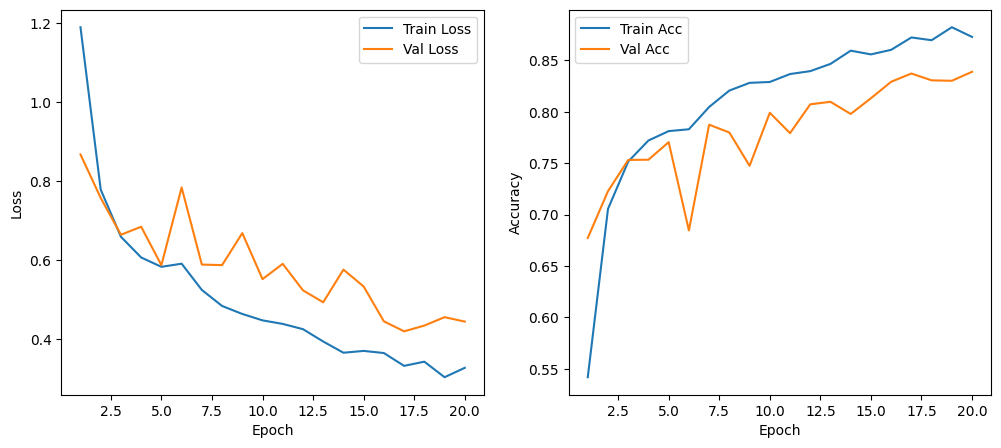

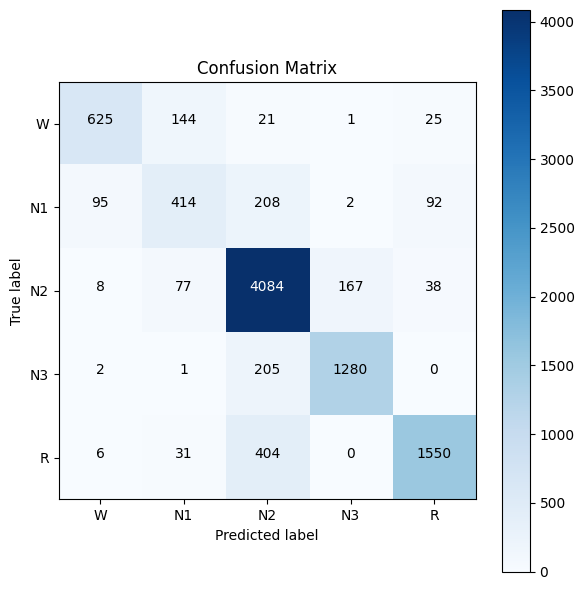

In [ ]:
if __name__ == '__main__':
    main()